## 0 - Librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import label_binarize
import seaborn as sns
from tensorflow.keras import optimizers
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.layers import BatchNormalization, RandomRotation, RandomTranslation, RandomZoom, RandomBrightness
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.config import run_functions_eagerly

2025-09-19 09:38:00.633775: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-19 09:38:00.722549: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-19 09:38:02.217655: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
run_functions_eagerly((True))

## 1 - Data Preparation

In [3]:
X_train = np.load("Images/train_images.npy") 
y_train = np.load("Images/train_labels.npy") 
X_test = np.load("Images/test_images.npy")  
y_test = np.load("Images/test_labels.npy")  

In [4]:
print(f'Shape of data X_train:{X_train.shape}\n')
print(f'Shape of data y_train:{y_train.shape}\n')
print(f'Shape of data X_test:{X_test.shape}\n')
print(f'Shape of data y_test:{y_test.shape}')

Shape of data X_train:(60000, 28, 28, 1)

Shape of data y_train:(60000,)

Shape of data X_test:(10000, 28, 28, 1)

Shape of data y_test:(10000,)


In [5]:
# Normalize images
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [6]:
# Reshape images for CNN model
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

## 2 - Data Viz

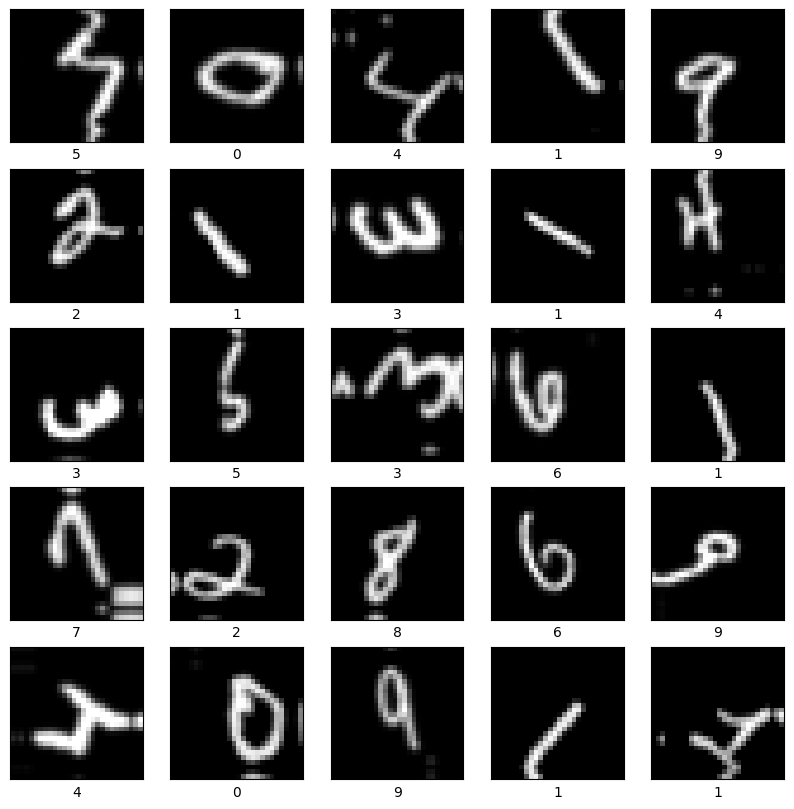

In [7]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.gray)
    plt.xlabel(y_train[i])
plt.show()

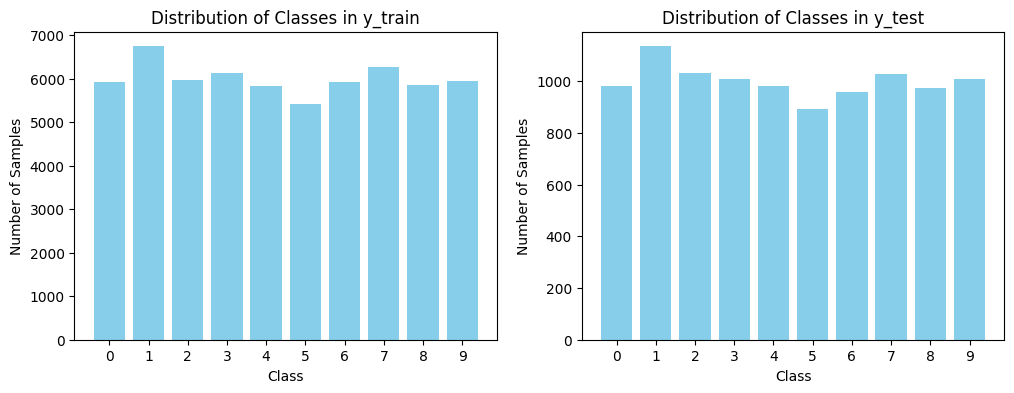

In [8]:
unique_classes_train, counts_train = np.unique(y_train, return_counts=True)
unique_classes_test, counts_test = np.unique(y_test, return_counts=True)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(unique_classes_train, counts_train, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_train')
plt.xticks(unique_classes_train)  

plt.subplot(1, 2, 2)
plt.bar(unique_classes_test, counts_test, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_test')
plt.xticks(unique_classes_test)  
plt.show()

## 3 - CNN Modele

### Parameters

In [9]:
# Parameters
epochs_cnn = 20
batch_size_cnn = 100
validation_split_cnn = .2
early_stop_cnn = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
k_folds = 5 
learning_rate_cnn = 0.001
metric_cnn = "accuracy"  #"SparseCategoricalAccuracy"

### Modele

In [10]:
# To have the same modifications that the perturbations
data_augmentation = Sequential([
    RandomRotation(0.2),
    RandomTranslation(0.2, 0.2),
    RandomZoom(0.2),
    RandomBrightness((-0.2, 0.2), [0.0, 1.0])
])

E0000 00:00:1758267483.989437   12510 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1758267484.004825   12510 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
def create_cnn_model():
    cnn_model = Sequential([
        #data_augmentation,
        Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, kernel_initializer='he_uniform', activation='relu'),
        Dropout(0.3),
        Dense(10, activation='softmax')
        ])

    cnn_model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate_cnn),
                    loss='sparse_categorical_crossentropy',
                    metrics=[metric_cnn]
        )
    return cnn_model

In [ ]:
skf = StratifiedKFold(n_splits=k_folds, shuffle=True)
fold_results = []
best_cnn_model = None
best_accuracy = 0.0
best_cnn_history = None

# Cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_cnn, y_train)):
    print(f"\nFold {fold + 1}/{k_folds}")


    X_train_fold, X_val_fold = X_train_cnn[train_idx], X_train_cnn[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # New model for the current fold
    cnn_model = create_cnn_model()

    # Train the model
    history = cnn_model.fit(
        X_train_fold, y_train_fold,
        epochs=epochs_cnn,
        batch_size=batch_size_cnn,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stop_cnn],
        verbose=1
    )

    # Evaluate the model
    val_loss, val_accuracy = cnn_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation accuracy for fold {fold + 1}: {val_accuracy:.4f}")

    # Store the results
    fold_results.append(val_accuracy)

    # Kepp the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_cnn_model = cnn_model
        best_cnn_history = history

# Print the result
print("\nCross-validation results:")
for i, accuracy in enumerate(fold_results):
    print(f"Fold {i + 1}: Validation accuracy = {accuracy:.4f}")

print(f"\nBest validation accuracy: {best_accuracy:.4f}")

# Retourner le meilleur modèle
print("\nBest model summary:")
best_cnn_model.summary()

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



Fold 1/5
Epoch 1/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 73s 152ms/step - accuracy: 0.4563 - loss: 1.5625 - val_accuracy: 0.2550 - val_loss: 2.2674
Epoch 2/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 74s 154ms/step - accuracy: 0.7143 - loss: 0.8681 - val_accuracy: 0.8299 - val_loss: 0.5487
Epoch 3/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 72s 151ms/step - accuracy: 0.7855 - loss: 0.6621 - val_accuracy: 0.8764 - val_loss: 0.3950
Epoch 4/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 73s 152ms/step - accuracy: 0.8184 - loss: 0.5629 - val_accuracy: 0.8905 - val_loss: 0.3590
Epoch 5/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 74s 154ms/step - accuracy: 0.8365 - loss: 0.5100 - val_accuracy: 0.7964 - val_loss: 0.6698
Epoch 6/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 70s 146ms/step - accuracy: 0.8506 - loss: 0.4624 - val_accuracy: 0.6857 - val_loss: 1.1046
Epoch 7/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 73s 151ms/step - accuracy: 0.8644 - loss: 0.4245 - val_accuracy: 0.9250 - val_loss: 0.2479
Epoch 8/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 72s 151ms/step - accuracy: 0.8711

### Results

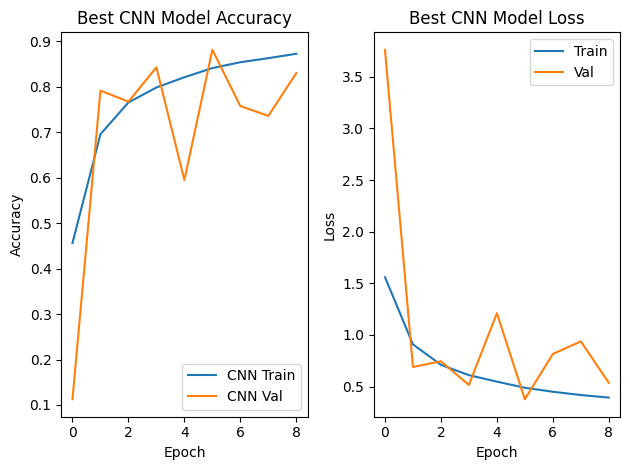

In [ ]:
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(best_cnn_history.history[accuracy], label='CNN Train')
plt.plot(best_cnn_history.history['val_' + accuracy], label='CNN Val')
plt.title('Best CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(best_cnn_history.history['loss'], label='Train')
plt.plot(best_cnn_history.history['val_loss'], label='Val')
plt.title('Best CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Predict classes using the cnn model
y_pred_cnn = best_cnn_model.predict(X_test_cnn)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


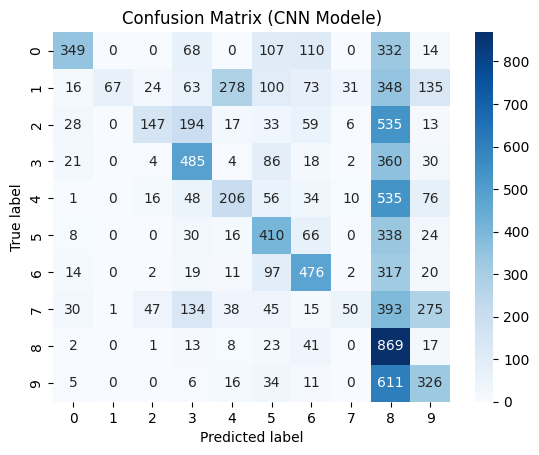

Class 0:
  Sensitivity (SEV): 0.3561
  Specificity (SPE): 0.9861

  F1-score: 0.4801

Class 1:
  Sensitivity (SEV): 0.0590
  Specificity (SPE): 0.9999

  F1-score: 0.1114

Class 2:
  Sensitivity (SEV): 0.1424
  Specificity (SPE): 0.9895

  F1-score: 0.2310

Class 3:
  Sensitivity (SEV): 0.4802
  Specificity (SPE): 0.9360

  F1-score: 0.4686

Class 4:
  Sensitivity (SEV): 0.2098
  Specificity (SPE): 0.9570

  F1-score: 0.2614

Class 5:
  Sensitivity (SEV): 0.4596
  Specificity (SPE): 0.9362

  F1-score: 0.4355

Class 6:
  Sensitivity (SEV): 0.4969
  Specificity (SPE): 0.9528

  F1-score: 0.5116

Class 7:
  Sensitivity (SEV): 0.0486
  Specificity (SPE): 0.9943

  F1-score: 0.0886

Class 8:
  Sensitivity (SEV): 0.8922
  Specificity (SPE): 0.5824

  F1-score: 0.3097

Class 9:
  Sensitivity (SEV): 0.3231
  Specificity (SPE): 0.9328

  F1-score: 0.3363



In [ ]:
# Confusion matrix
matrix = confusion_matrix(y_test, y_pred_classes_cnn)  # Compare true labels (y_test) and predicted labels (y_pred_classes_dense)

# Plot confusion matrix
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (CNN Modele)')
plt.show()

# Calculate Sensitivity (SEV) and Specificity (SPE) for each class
for i in range(matrix.shape[0]):
    tp = matrix[i, i]
    fn = np.sum(matrix[i, :]) - tp
    fp = np.sum(matrix[:, i]) - tp
    tn = np.sum(matrix) - tp - fn - fp
    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0  # F1-score
    sev = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity (Recall)
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
    accuracy = (tn + tp) / (tp + fn + tn + fp)
    print(f'Class {i}:')
    print(f'  Sensitivity (SEV): {sev:.4f}')
    print(f'  Specificity (SPE): {spe:.4f}')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  F1-score: {f1:.4f}\n')

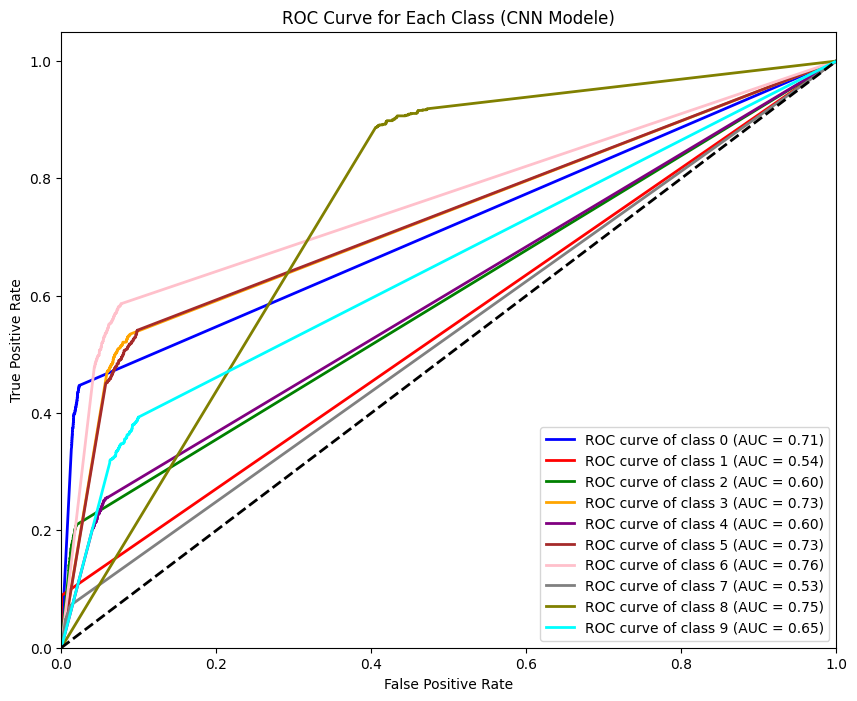

In [ ]:
# Binarize the output for ROC curve (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_cnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (CNN Modele)')
plt.legend(loc="lower right")
plt.show()